In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

# 1. data file descriptions

In [2]:
import polars as pl


base_folder = "/kaggle/input/jane-street-real-time-market-data-forecasting/"

## 1.1 responder.csv

- responder.csv: metadata pertaining to the anonymized responders. Note that we only consider reponder_6.

In the context of the real market, a "responder" typically refers to an individual or entity that actively reacts to market events or changes, often by placing orders to buy or sell assets based on the current market conditions.

- Individual Investor: This refers to a person who actively participates in the market by buying and selling securities.
- Institutional Investor: This includes entities like pension funds, mutual funds, hedge funds, and insurance companies that invest large sums of money in the market.
- Brokerage Firms: These intermediaries facilitate transactions between buyers and sellers of securities.
- Market Makers: These specialized firms provide liquidity to the market by buying and selling securities at their own risk.

In [ ]:
df_responder = pl.read_csv(f"{base_folder}/responders.csv")
df_responder
# The tags are used to 'group' the features and responders

## 1.2 feature.csv

metadata pertaining to the anonymized features

conclusion: no need to use

In [ ]:
df_features = pl.read_csv(f"{base_folder}/features.csv")
df_features.head()
# The tags are used to 'group' the features and responders

## 1.3 train data

The training set, contains historical data and returns. For convenience, the training set has been partitioned into ten parts.
- date_id and time_id - Integer values that are ordinally sorted, providing a chronological structure to the data, although the actual time intervals between time_id values may vary.
- symbol_id - Identifies a unique financial instrument.
- weight - The weighting used for calculating the scoring function.
- feature_{00...78} - Anonymized market data.
- responder_{0...8} - Anonymized responders clipped between -5 and 5. The responder_6 field is what you are trying to predict. Note that this is the target.

In [ ]:
i = 4 # [0-9]
df_train_i = pl.read_parquet(f"{base_folder}/train.parquet/partition_id={i}/part-0.parquet")
df_train_i.head()

## 1.4 test data

A mock test set which represents the structure of the unseen test set. This example set demonstrates a single batch served by the evaluation API, that is, data from a single date_id, time_id pair. The test set contains columns including date_id, time_id, symbol_id, weight, is_scored, and feature_{00...78}. You will not be directly using the test set or sample submission in this competition, as the evaluation API will get/set the test set and predictions.
- is_scored - Indicates whether this row is included in the evaluation metric calculation.

In [ ]:
df_test = pl.read_parquet(f"{base_folder}/test.parquet/date_id=0/part-0.parquet")
df_test.head()

## 1.5 lag data

Values of responder_{0...8} lagged by one date_id. The evaluation API serves the entirety of the lagged responders for a date_id on that date_id's first time_id. In other words, all of the previous date's responders will be served at the first time step of the succeeding date.

When a new date_id begins (at its first time_id), the API provides ALL of the responder values from the previous date

what is a lag value? A lag is the time difference between two observations in a sequence. In this case the lags are provided at date_id-1, this means that for every prediction of a specific date we will the responders values of the previous date. Indeed it could happen that there's a correlation between the responders as it could happen in a real market.

For example: on January 2nd's first timestep, you get all of January 1st's responder values

Instead of getting updates throughout the day, you receive all of yesterday's data first thing in the morning. This lag ensures you have complete information from the previous period before making any decisions or calculations for the current period.


conclusion: this is important

In [ ]:
df_lag = pl.read_parquet(f"{base_folder}/lags.parquet/date_id=0/part-0.parquet")
df_lag.head()

In the competition only a small sample is provided and if we want to play with the lags to train our model we will have to create the lags on our own from the traning data. Indeed in the training data we have the values of the responder at the date_id for a specific time_id and while when testing we will have the values at the date-1 being the lag_1 (i.e. from the previous date).

# 2. EDA

In [3]:
import dask.dataframe as dd

In [4]:
train_data = dd.read_parquet(f"{base_folder}/train.parquet")
train_data.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504,0
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639,0
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828,0
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516,0
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000,0


## 2.1 Train Data analysis

In [5]:
# calcualte how many time_id for each date_id
time_id_per_day = train_data.groupby("date_id")["time_id"].nunique().compute()
time_id_per_day = time_id_per_day.sort_index() # sort according to date_id
time_id_per_day.head()

date_id
0    849
1    849
2    849
3    849
4    849
Name: time_id, dtype: int64

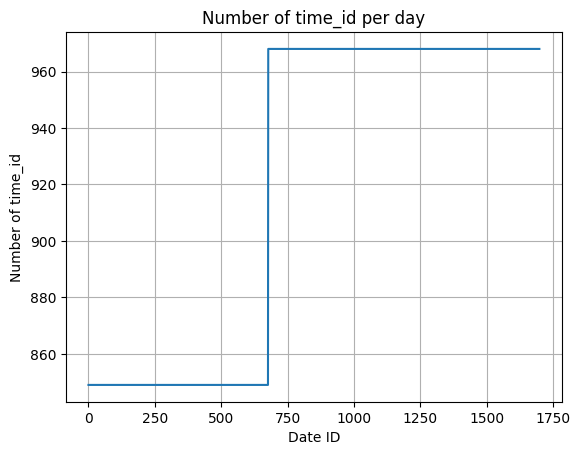

In [6]:
import matplotlib.pyplot as plt

x = time_id_per_day.index.to_numpy()
y = time_id_per_day.values

plt.plot(x, y)
plt.xlabel("Date ID")
plt.ylabel("Number of time_id")
plt.title("Number of time_id per day")
plt.grid()
plt.show()

we can observe that every day we have 849 time_id before the date_id=677. After this date id we have 968 time_id per day.

In [7]:
# calcualte how many symbol_id for each date_id
symbol_id_per_day = train_data.groupby("date_id")["symbol_id"].nunique().compute()
symbol_id_per_day = symbol_id_per_day.sort_index() # sort according to date_id
symbol_id_per_day.head()

date_id
0     8
1    12
2    11
3    12
4    12
Name: symbol_id, dtype: int64

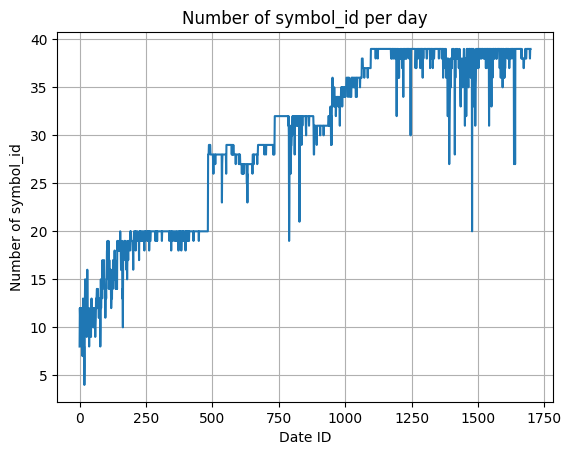

In [8]:
x = symbol_id_per_day.index.to_numpy()
y = symbol_id_per_day.values

plt.plot(x, y)
plt.xlabel("Date ID")
plt.ylabel("Number of symbol_id")
plt.title("Number of symbol_id per day")
plt.grid()
plt.show()

We can observe that for each date we don't have a constant number of symbols but they vary day by day.

## 2.2 responder analysis

In [ ]:
import re

pattern = re.compile('^responder_')
responders = train_data[list(filter(pattern.match, train_data.columns))]
responders.head()

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(responders.corr(), 
            annot=True,          # Show correlation values
            square=True,         # Make the plot square
            cmap="jet",         
            fmt='.2f',          # Round correlation values to 2 decimal places
            vmin=-1, vmax=1)    # Set correlation range from -1 to 1

plt.xlabel("responder_0  -  responder_8")
plt.ylabel("responder_0  -  responder_8")
plt.show()

From the correlation matrix we can observe as responder 6 is strongly correlated for each time id with responder 3 and weakly with 0,1,2.

A proper model should therefore not only rely on the features but also on the other values of the responders.

# 3. Metric

The metric should be interpreted as follow:

R2 =1: Perfect fit (all predictions match true values, accounting for weights)
R2 =0: Predictions are as good as using the weighted mean
R2<0: Model performs worse than using the weighted mean

# 4. Model

based on the notebook: https://www.kaggle.com/code/simonedegasperis/starter-eda in `Predictions` Section,

[1] simple linear model fitted on the 33% of the total data doesn't allow to achieve better results than a very simple constant model. The time series is highly no stationary.
[2] The R2 metric achieved with the xgboost is lower than the simple constant method. Then adding lags information is important.

# 5. Lags

we have observed the imporance of lags, so we directly create the lags here.

In [ ]:
class CONFIG:
    target_col = "responder_6"
    lag_cols_original = ["date_id", "symbol_id"] + [f"responder_{idx}" for idx in range(9)]
    lag_cols_rename = { f"responder_{idx}" : f"responder_{idx}_lag_1" for idx in range(9)}
    valid_ratio = 0.05
    start_dt = 1250 # start with a more recent start date

## 5.1 merge data

In [ ]:
# load training data
import polars as pl

train_data = pl.scan_parquet(f"{base_folder}/train.parquet"
                            ).select(
    pl.int_range(pl.len(), dtype=pl.UInt32).alias("id"),
    pl.all(),
).with_columns(
    (pl.col(CONFIG.target_col)*2).cast(pl.Int32).alias("label"),
).filter(
    pl.col("date_id").gt(CONFIG.start_dt)
)

lags = train_data.select(pl.col(CONFIG.lag_cols_original))
lags = lags.rename(CONFIG.lag_cols_rename)
lags = lags.with_columns(date_id = pl.col('date_id') + 1) # lagged by 1 day
lags = lags.group_by(["date_id", "symbol_id"], maintain_order=True).last()  # pick up last record of previous date
lags.head()

In [ ]:
lag_train = train_data.join(lags, on=["date_id", "symbol_id"],  how="left")
lag_train.head()

## 5.2 split train and test

In [ ]:
# len_train   = len(lag_train['date_id'].unique())
len_train = lag_train.select(pl.col("date_id")).collect().shape[0]
valid_records = int(len_train * CONFIG.valid_ratio)
len_ofl_mdl = len_train - valid_records
# last_tr_dt  = lag_train['date_id'].unique()[len_ofl_mdl]
last_tr_dt  = lag_train.select(pl.col("date_id")).collect().row(len_ofl_mdl)[0]

print(f"\n len_train = {len_train}")
print(f"\n len_ofl_mdl = {len_ofl_mdl}")
print(f"\n---> Last offline train date = {last_tr_dt}\n")

In [ ]:
training_data = lag_train.filter(pl.col("date_id").le(last_tr_dt))
training_data.head()

In [ ]:
validation_data   = lag_train.filter(pl.col("date_id").gt(last_tr_dt))
validation_data.head()

## 5.3 save train and val data

In [ ]:
training_data.collect().\
write_parquet(
    f"training.parquet", partition_by = "date_id",
)

validation_data.collect().\
write_parquet(
    "validation.parquet", partition_by = "date_id",
)